<a href="https://colab.research.google.com/github/Mahdi-Golizadeh/VarationalAutoEncoders/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm.notebook import tqdm
import os
import shutil
%matplotlib inline
%config InlineBackend.figure_format = "svg"
plt.style.use("ggplot")
random.seed(49)

In [2]:
epochs = 1000
batch_size = 64
torch.manual_seed(49)
torch.cuda.manual_seed(49)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {device}")

device is cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Font.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Font/all/Sample024/img024-00543.png  
  inflating: __MACOSX/Font/all/Sample024/._img024-00543.png  
  inflating: Font/all/Sample024/img024-00219.png  
  inflating: __MACOSX/Font/all/Sample024/._img024-00219.png  
  inflating: Font/all/Sample024/img024-00386.png  
  inflating: __MACOSX/Font/all/Sample024/._img024-00386.png  
  inflating: Font/all/Sample024/img024-00392.png  
  inflating: __MACOSX/Font/all/Sample024/._img024-00392.png  
  inflating: Font/all/Sample024/img024-00423.png  
  inflating: __MACOSX/Font/all/Sample024/._img024-00423.png  
  inflating: Font/all/Sample024/img024-00345.png  
  inflating: __MACOSX/Font/all/Sample024/._img024-00345.png  
  inflating: Font/all/Sample024/img024-00351.png  
  inflating: __MACOSX/Font/all/Sample024/._img024-00351.png  
  inflating: Font/all/Sample024/img024-00437.png  
  inflating: __MACOSX/Font/all/Sample024/._img024-00437.png  
  inflating: Font/all/Sample024/img024-00379.

In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels= 1),
    torchvision.transforms.Resize(size= 50),
    torchvision.transforms.ToTensor(),
])

In [6]:
data_batch = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder("Font/all",
    transform= torchvision.transforms.ToTensor()),
    batch_size= 1,
    shuffle= True
)

In [7]:
sample = next(iter(data_batch))

In [8]:
sample[1].shape

torch.Size([1])

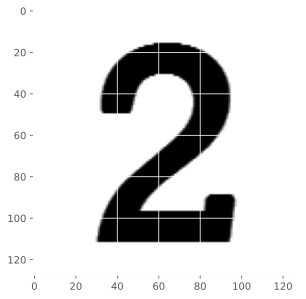

In [9]:
plt.imshow(sample[0][0].permute(1, 2, 0), cmap= "gray")

In [10]:
sample_1_t = transforms(torchvision.transforms.ToPILImage()(sample[0][0]))

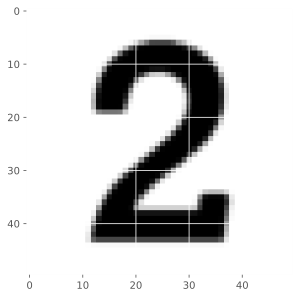

In [11]:
plt.imshow(sample_1_t.squeeze(), cmap= "gray")

In [12]:
folder = [f for f in os.listdir("Font/all") if f[0] != "."]
# os.listdir("Font/all")

In [13]:
folder

['Sample058',
 'Sample048',
 'Sample001',
 'Sample020',
 'Sample018',
 'Sample007',
 'Sample045',
 'Sample017',
 'Sample004',
 'Sample061',
 'Sample037',
 'Sample040',
 'Sample031',
 'Sample055',
 'Sample052',
 'Sample062',
 'Sample012',
 'Sample027',
 'Sample060',
 'Sample010',
 'Sample054',
 'Sample019',
 'Sample008',
 'Sample015',
 'Sample028',
 'Sample026',
 'Sample016',
 'Sample041',
 'Sample033',
 'Sample051',
 'Sample039',
 'Sample025',
 'Sample057',
 'Sample013',
 'Sample030',
 'Sample046',
 'Sample043',
 'Sample011',
 'Sample034',
 'Sample053',
 'Sample029',
 'Sample044',
 'Sample003',
 'Sample006',
 'Sample036',
 'Sample049',
 'Sample042',
 'Sample005',
 'Sample021',
 'Sample009',
 'Sample038',
 'Sample056',
 'Sample035',
 'Sample059',
 'Sample023',
 'Sample002',
 'Sample050',
 'Sample014',
 'Sample032',
 'Sample024',
 'Sample047',
 'Sample022']

In [14]:
if not(os.path.isdir("train")):
    os.mkdir("train")

if not(os.path.isdir("eval")):
    os.mkdir("eval")

In [15]:
for f in tqdm(folder):
    if not(os.path.isdir(f"eval/{f}")):
        os.mkdir(f"eval/{f}")
    if not(os.path.isdir(f"train/{f}")):
        os.mkdir(f"train/{f}")

    images = [image for image in os.listdir(f'Font/all/{f}') if image[0]!='.']

    random.shuffle(images)
    for image in images[:20]:
        shutil.copy(f'Font/all/{f}/{image}', f'eval/{f}/{image}')
        
    for image in images[20:]:
        shutil.copy(f'Font/all/{f}/{image}', f'train/{f}/{image}')

  0%|          | 0/62 [00:00<?, ?it/s]

In [16]:
# shutil.rmtree("Font")

In [59]:
train_data_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        "train", transform= transforms
    ),
    batch_size= batch_size,
    shuffle= True
)
eval_data_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        "eval", transform= transforms
    ),
    batch_size= batch_size,
    shuffle= True
)

In [18]:
class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        hidden_dim = 32
        self.fc_1 = torch.nn.Linear(50 * 50, 1000)
        self.fc_2_1 = torch.nn.Linear(1000, hidden_dim)
        self.fc_2_2 = torch.nn.Linear(1000, hidden_dim)
        self.fc_3 = torch.nn.Linear(hidden_dim, 1000)
        self.fc_4 = torch.nn.Linear(1000, 50 * 50)

    def encode(self, x):
        h_1 = torch.nn.functional.relu(self.fc_1(x))
        return self.fc_2_1(h_1), self.fc_2_2(h_1)
    
    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h_3 = torch.nn.functional.relu(self.fc_3(z))
        return torch.sigmoid(self.fc_4(h_3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 50*50))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

In [19]:
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 50*50), reduction='sum'
        )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [20]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
os.mkdir("Results/")
os.mkdir("Models/")

In [67]:
def evaluate(evaluate_data=eval_data_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(evaluate_data):
            
            data = data.to(device)
            
            recon_batch, mu, logvar = model(data)
            
            val_loss += loss_function(recon_batch, data, mu, logvar).item()
            plt.clf()
            if i == 0:
                n = min(data.size(0), 16)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 50, 50)[:n]])
                img = torchvision.utils.make_grid(comparison)
                plt.imshow(img.permute(1, 2, 0).cpu().numpy())
                plt.show()
    val_loss /= len(evaluate_data.dataset)
    return val_loss


def sample_latent_space(epoch):
    with torch.no_grad():
        sample = torch.randn(64, 32).to(device)
        sample = model.decode(sample).cpu()
        torchvision.utils.save_image(sample.view(64, 1, 50, 50),
                   'Results/sample_' + str(epoch) + '.png')

In [27]:
def train(epoch):

    model.train()
    train_loss = 0
    
    progress_bar = tqdm(train_data_loader, desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)
    for data, _ in progress_bar:
        
        data = data.to(device)
        
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        
        optimizer.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(data))})

    average_train_loss = train_loss / len(train_data_loader.dataset)
    tqdm.write('Training set loss (average, epoch {:03d}): {:.3f}'.format(epoch, average_train_loss))
    val_loss = evaluate(eval_data_loader)
    tqdm.write('\t\t\t\t====> Validation set loss: {:.3f}'.format(val_loss))

    train_losses.append(average_train_loss)
    val_losses.append(val_loss)
    
    if epoch%50==0:
        torch.save(model.state_dict(), f'Models/epoch_{epoch}.model')

In [69]:
epochs=20

Epoch 001:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 001): 248.039


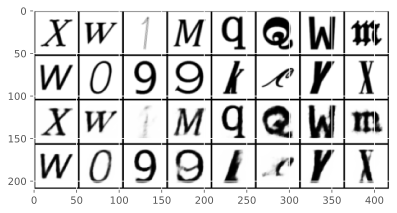

				====> Validation set loss: 252.244


Epoch 002:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 002): 247.815


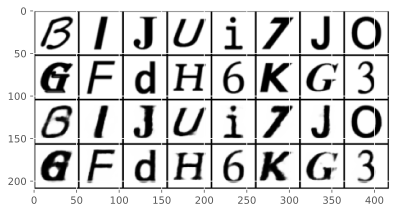

				====> Validation set loss: 252.159


Epoch 003:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 003): 247.924


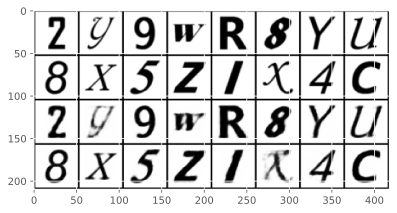

				====> Validation set loss: 251.694


Epoch 004:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 004): 247.919


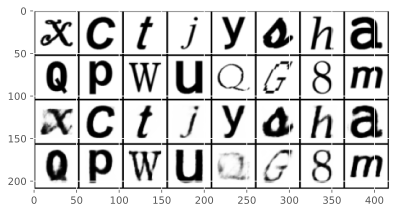

				====> Validation set loss: 251.770


Epoch 005:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 005): 247.565


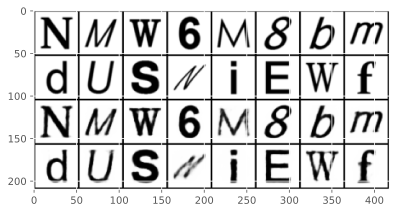

				====> Validation set loss: 252.618


Epoch 006:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 006): 247.514


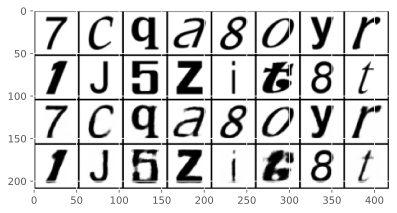

				====> Validation set loss: 250.889


Epoch 007:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 007): 247.302


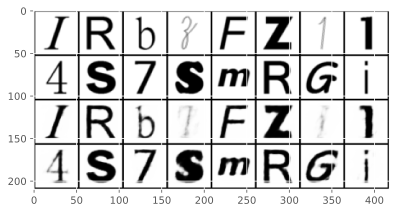

				====> Validation set loss: 250.820


Epoch 008:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 008): 247.170


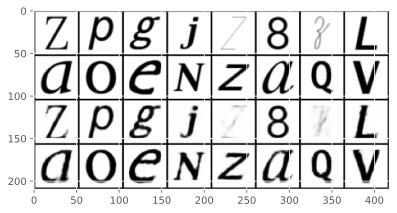

				====> Validation set loss: 251.203


Epoch 009:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 009): 247.086


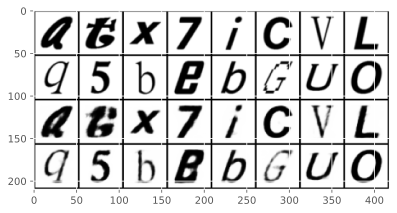

				====> Validation set loss: 250.202


Epoch 010:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 010): 246.899


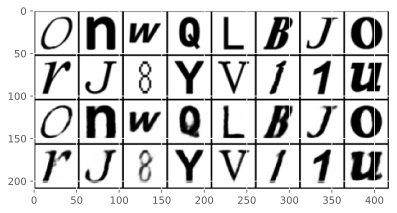

				====> Validation set loss: 252.003


Epoch 011:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 011): 246.809


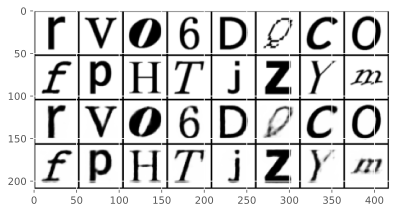

				====> Validation set loss: 250.542


Epoch 012:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 012): 247.100


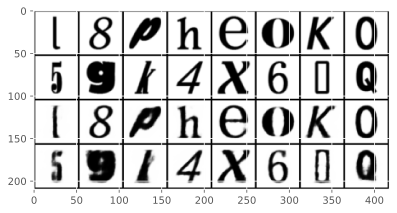

				====> Validation set loss: 250.251


Epoch 013:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 013): 246.672


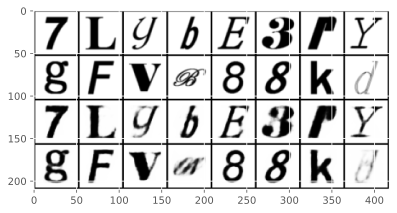

				====> Validation set loss: 253.320


Epoch 014:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 014): 246.527


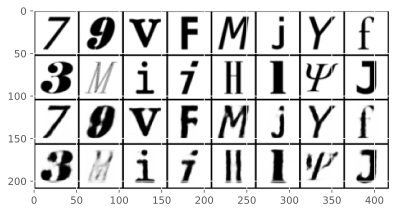

				====> Validation set loss: 249.338


Epoch 015:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 015): 246.581


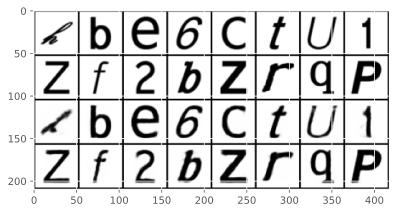

				====> Validation set loss: 252.230


Epoch 016:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 016): 246.605


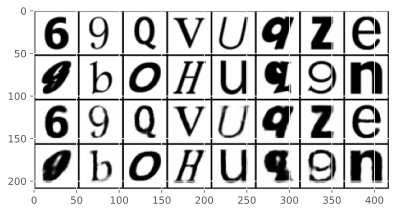

				====> Validation set loss: 250.168


Epoch 017:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 017): 246.399


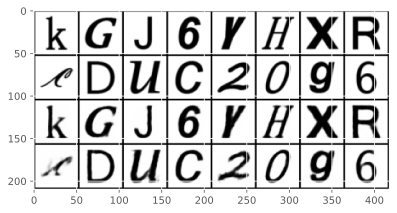

				====> Validation set loss: 251.891


Epoch 018:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 018): 246.359


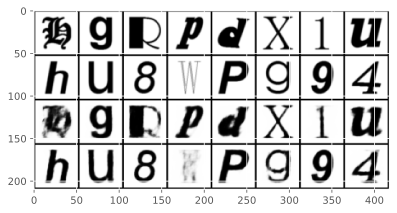

				====> Validation set loss: 251.796


Epoch 019:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 019): 246.009


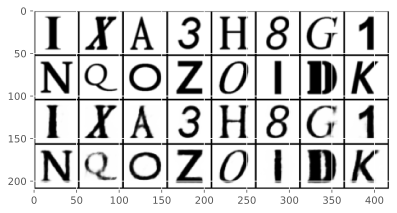

				====> Validation set loss: 249.401


Epoch 020:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 020): 246.134


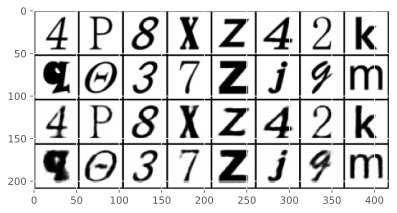

				====> Validation set loss: 250.321


<Figure size 640x480 with 0 Axes>

In [70]:
train_losses = []
val_losses = []

for epoch in range(1, epochs+1):
    train(epoch)
    sample_latent_space(epoch)
    
np.savetxt('Models/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt('Models/validation_losses.txt', np.array(val_losses), delimiter='\n')

In [30]:
for i in range(100):
    sample_latent_space(f'-{i}')

In [71]:
train_losses = np.loadtxt('Models/training_losses.txt')
val_losses = np.loadtxt('Models/validation_losses.txt')

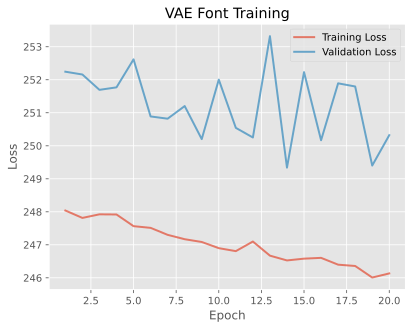

In [72]:
plt.plot(
    range(1, len(train_losses)+1), 
    train_losses, 
    label='Training Loss',
    linewidth=2, 
    alpha=0.7
)

plt.plot(
    range(1, len(val_losses)+1),
    val_losses,
    label='Validation Loss',
    linewidth=2,
    alpha=0.7
)

plt.title('VAE Font Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()